# Preprocess Africell Four Months Data
Since the four months came without column headers and the columns are somehow different from those in the previous dataset, I select only a few required columns and also anonymise the phonenumbers.

In [48]:
import os
from datetime import datetime
import time
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
import numpy as np
from pyspark.sql.types import Row
from pyspark.sql import SparkSession
from cdr_data_utils import cell_based_operations as cb
from pyspark.sql.types import *
from pyspark.sql.functions import collect_set, from_unixtime, unix_timestamp, col, udf, datediff, pandas_udf, PandasUDFType,lit, struct, monotonically_increasing_id

## Global Variables
A param variable will be defined globally to get around some issue with passing multiple params into spark UDF

In [24]:
def plot_and_save_distance_distribution(df=None, plot_col=None, lu_class=None, outfile=None, 
                                        region=None, custom_ticks=None):
    if region != 'SL':
        df = df[df.western == 1]
    plt.figure(figsize=(12,8))
    ax = sns.distplot(df[plot_col])
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    if custom_ticks:
        ax.set_xticks(custom_ticks)
    ax.set_xlabel('Distance (Km)')
    ax.set_ylabel('Frequency')
    ax.set_title('Cell Towers Distance to Nearest POI for {}'.format(region))
    # Save
    plt.savefig(outfile)
    plt.show()

In [2]:
pois = "../data/geography/POI/hotosm-POIs.csv"
dfp = pd.read_csv(pois)

In [8]:
cells = "../data/geography/cell-towers/africell/africell-loc-with-admin-attributes.csv"
dfc = pd.read_csv(cells)
dfc.drop_duplicates(subset=['site_id'], inplace=True)

In [10]:
# add distance to POIs
dfc2 = cb.distance_to_nearest_pois(poi_file=pois, dflu=dfc,
                                                filter_pois=False)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


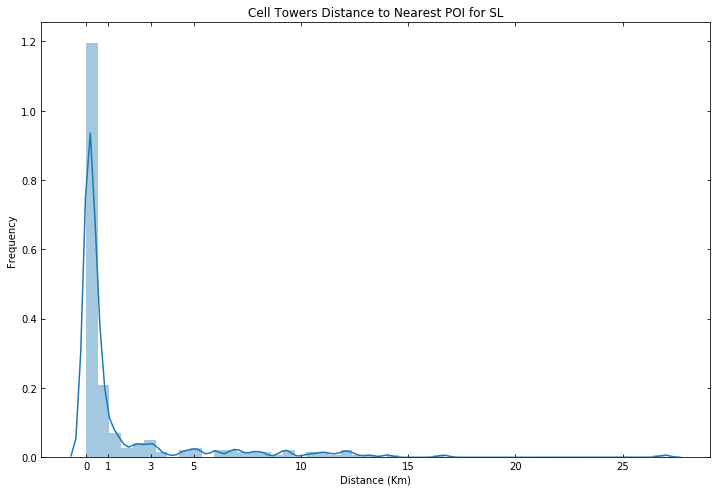

In [21]:
outf = "../outputs/cellTowers/distance_to_nearest_POI_SL.png"
plot_and_save_distance_distribution(df=dfc2, plot_col='nearest_dist', lu_class='both', 
                                    outfile=outf, region='SL', custom_ticks = [0, 1, 3, 5, 10, 15, 20, 25])

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


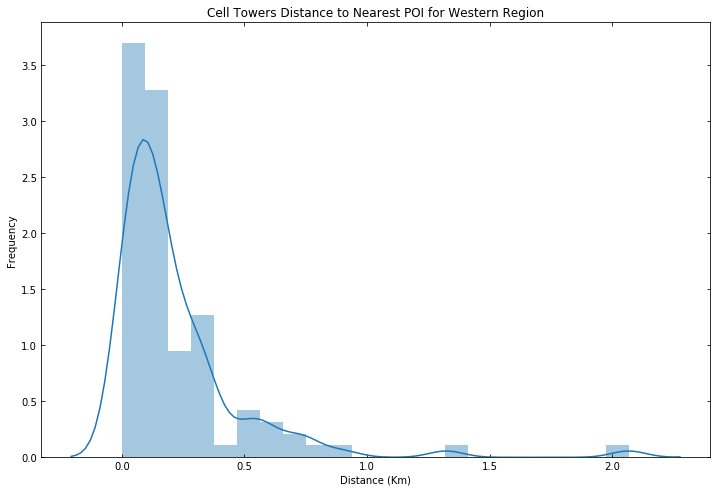

In [25]:
outf = "../outputs/cellTowers/distance_to_nearest_POI_western.png"
plot_and_save_distance_distribution(df=dfc2, plot_col='nearest_dist', lu_class='both', 
                                    outfile=outf, region='Western Region')

In [31]:
df_west = dfc2[dfc2.western == 1]
df_west.nearest_dist.describe()

count    101.000000
mean       0.224156
std        0.287526
min        0.002592
25%        0.063643
50%        0.139602
75%        0.287146
max        2.066389
Name: nearest_dist, dtype: float64

In [68]:
def plot_and_save_num_trips_CDF(df=None, operator=None, region=None, outfile=None, add_lines=True,
                               custom_ticks=None):
    plt.figure(figsize=(12,8))
    ax = sns.distplot(df['nearest_dist'], hist_kws=dict(cumulative=True),kde_kws=dict(cumulative=True))
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.set_xlabel('Distance (km) to nearest POI')
    if custom_ticks:
        ax.set_xticks(custom_ticks, which='major')   
    ax.set_ylabel('Frequency')
    ax.set_title('{}, {}: CDF for Cell Tower Distance to Nearest OSM POI'.format(operator, region))
    if add_lines:
        plt.axhline(y=0.95, linewidth=2, color='r')
        plt.axvline(x=9.172, linewidth=2, color='b')
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(80, 0.82, '95 percentile',  fontsize=14, verticalalignment='top', bbox=props)
        
    # Save
    plt.savefig(outfile)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


TypeError: set_xticks() got an unexpected keyword argument 'which'

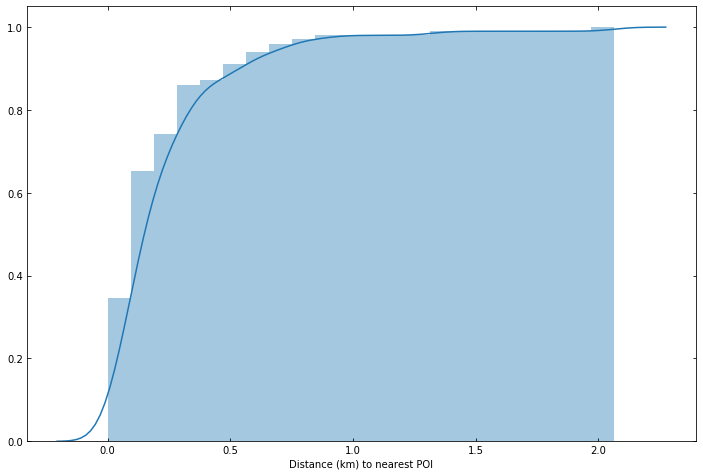

In [69]:
outf_cdf = "../outputs/cellTowers/CDF_distance_to_nearest_POI_western.png"
plot_and_save_num_trips_CDF(df=df_west, operator='Africell', region='Western Region', outfile=outf_cdf, 
                            add_lines=True, custom_ticks=[0, 0.5, 1, 1.5, 2])

In [65]:
df_west.nearest_dist.quantile(0.95)

0.7195449533983603

In [145]:
# a global dict variable to hold all key params
PARAMS = None

## Define Utility Spark UDF

In [170]:
def add_home_work_transit_category(target_hr):
    """
    Categorise given hour as work, home or transit using passed params
    returns: 1. for home, 2. for work and 3 for transit
    """
    # utilise global PARAM variable to retrive these values
    home = PARAMS['home_hrs']
    work = PARAMS['work_hrs']
    trst = PARAMS['transit_hrs']
    
    if target_hr in home:
        return 'home'
    elif target_hr in work:
        return 'work'
    else:
        return 'transit'

In [174]:
add_datetime = udf(lambda x: datetime.strptime(x[:-4], datetime_fmt), TimestampType())
add_date = udf(lambda x: datetime.strptime(x[:-4], datetime_fmt), DateType())
add_hr = udf(lambda x: x.hour, IntegerType())
add_month = udf(lambda x: x.month, IntegerType())
# for weekday, we use weekday() where where Monday is 0 and Sunday is 6
add_wkday = udf(lambda x: x.weekday(), IntegerType())
add_date_str = udf(lambda x: datetime.strftime(x, date_fmt), StringType())
add_lu_class = udf(lambda x : add_home_work_transit_category(x), StringType())

In [114]:
def read_and_preprocess_raw_cdrs(cdrs_path=None, loc_file=None, spark=None, 
                                 datetime_fmt="%Y-%m-%d %H:%M:%S", date_fmt="%Y-%m-%d"):
    """
    For the purpose of generating outputs by cellTower, this function
    ingests raw CDRs, preprocesses and returns data stored by cellid
    """
    # read into DF
    df = spark.read.csv(cdrs_path, header=False)

    # keep only a few columns
    cols_to_keep = ["_c1", "_c6", "_c14", "_c15"]
    df2 = df.select(*cols_to_keep)
    df3 = (df2.withColumnRenamed("_c1", "datetime")
        .withColumnRenamed("_c14", "cellid"))

    # hash phone numbers
    hash_numbers = udf(lambda z: abs(hash(str(z))), StringType())
    df4 = df3.withColumn("phonenumber1", hash_numbers(col("_c6")))
    df5 = df4.withColumn("phonenumber2", hash_numbers(col("_c15")))
    df6 = df5.drop(*["_c6", "_c15"])

    # add location
    dfloc = spark.read.csv(loc_file, header=True)
    dfloc2 = dfloc.withColumnRenamed('cell_id', 'cellid')
    df7 = df6.repartition(20)
    df8 = df7.join(dfloc2, on='cellid', how='inner')
    
    # create required time variables
    df9 = df8.withColumn('datetime2', add_datetime(col('datetime')))
    df10 = df9.withColumn('date', add_date(col('datetime')))
    df11 = df10.withColumn('month', add_month(col('datetime2')))
    df12 = df11.drop('datetime')
    df13 = df12.withColumnRenamed("datetime2", "datetime")
    df14 = df13.withColumn('hr', add_hr(col('datetime')))
    df15 = df14.withColumn('wkday', add_wkday(col('datetime')))
    df16 = df15.withColumn('date_str', add_date_str(col('datetime')))
    
    return df16

In [51]:
def create_date_objects(date_str=None, fmt=None):
    """
    Utility to create date object for holidays
    """
    return   datetime.strptime(date_str, fmt)

In [99]:
def prep_lu_classification_parameters(home_hrs=None, work_hrs=None, transit_hrs=None, 
                                      holidays=None, exclude_holidays=True, timestamp=None,
                                      hr=None, datecol=None, date_fmt=None, results_file=None, 
                                      exclude_wkends=False, outparam_file=None):
    """
    Compiles params for easy recording
    :param home_hrs: which hours to consider as home 
    :param work_hrs: which hours to consider as work 
    :param transit_hrs: hours which dont fall into home or work
    :param holidays: Public holidays
    :param exclude_holidays:  whether to exclude holidays or not
    :param exclude_wkends: whether toexclude weekends or not
    :param outparam_file: save param file to link with results 
    :return: a dict of params
    """
    # hardcoding now but can easily be overrided with arg
    home_hrs = [20, 21, 22, 23] + [i for i in range(0, 7)]
    transit_hrs = [7, 8, 19]
    work_hrs = [i for i in range(9, 19)]
    check_hrs = sorted(home_hrs + transit_hrs + work_hrs)
    assert check_hrs == [i for i in range(0, 24)]
    
    # public holidays for 2018
    hldy_strs = ['2018-01-01', '2018-03-08', '2018-03-30','2018-04-02',
                 '2018-04-27', '2018-06-15', '2018-08-21', '2018-11-20',
                 '2018-12-25', '2018-12-26']
    hldy_obj = [create_date_objects(date_str=d, fmt=date_fmt) for d in hldy_strs]

    # put togather all params
    params = {'datetime_col': timestamp,'home_hrs': home_hrs, 'work_hrs': work_hrs,
              'transit_hrs': transit_hrs, 'holidays': hldy_strs, 'hr_col': hr,
              'exclude_hldys': exclude_holidays, 'exclude_wkends': exclude_wkends,
              'date_col':datecol
             }
    
    # write important params to file
    f = open(outparam_file, "a")
    f.write("\n")
    f.write("===========================\n")
    f.write("Parameters Profile\n")
    f.write("===========================\n")
    
    time_created = datetime.now().ctime()
    f.write("Time Created:  {} \n".format(time_created))
    f.write("Results File:  {} \n".format(results_file))
    f.write("-----------------------------------------------\n")
    f.write("\n")
    for k, v in params.items():
        f.write("{} :  {} \n".format(k,v))
            
    f.write("++++++++++++++++++++++++++++++++++++++++++++++++\n")
    f.write("\n")
    return params

In [250]:
def assign_lu_class_using_maximum_prop(x, std_threshold):
    """
    A site is given a class with largest proporiton of calls
    """
    props = {'home': x['prop_h'], 'work': x['prop_w'], 'transit': x['prop_t']}
    
    if x['prop_std'] > std_threshold:
        return max(props, key=props.get)
    else:
        return 'mixed'

In [252]:
def classify_into_lu(how ='simple_max', df=None, std_threshold=0.05):
    """
    Assign LU class to each site based on approach
    """
    # add proportions
    df['total'] = df.sum(axis=1)
    df['prop_h'] = df.apply(lambda x: x['home'] / x['total'], axis=1)
    df['prop_w'] = df.apply(lambda x: x['work'] / x['total'], axis=1)
    df['prop_t'] = df.apply(lambda x: x['transit'] / x['total'], axis=1)
    df['prop_std'] = df.apply(lambda x: np.std([x['prop_h'], x['prop_w'], x['prop_t']]), axis=1)

    if how == 'simple_max':
        std_threshold = 0.0
        df['lu_class'] = df.apply(assign_lu_class_using_maximum_prop, args=(std_threshold,), axis=1)
    else:
        df['lu_class'] = df.apply(assign_lu_class_using_maximum_prop, args=(std_threshold,), axis=1)

    return df

In [6]:
spark = SparkSession.builder.master("local[12]").appName("data_processor").getOrCreate()

In [288]:
cdrs = "../data/africell/sample.txt"
loc = "../data/geography/cell-towers/africell/africell-loc-with-admin-attributes.csv"
params_file = "../outputs/cellTowers/cellTowerClassificationParamsLog.txt"
dfloc = read_and_preprocess_raw_cdrs(cdrs_path=cdrs, loc_file=loc, spark=spark)

In [279]:
dfloc.head()

Row(cellid='34090', phonenumber1='4922434041089106118', phonenumber2='231238235533002469', operator='africell', site_id='s67', lon='-13.2289', lat='8.48674', within_frt='1', western='1', lac='800', azimuth='90', beam_width='43', cell_name='3G_GODRECHSTREET-13', mcc='619', mnc='5', admin4Name='Mountain Regent', admin4Pcod='SL04020102', admin3Name='Central I', admin3Pcod='SL040201', admin2Name='Western Area Urban', admin2Pcod='SL0402', admin1Name='Western', admin1Pcod='SL04', popCnt2015='8132.562', datetime=datetime.datetime(2018, 1, 27, 14, 17, 43), date=datetime.date(2018, 1, 27), month=1, hr=14, wkday=5, date_str='2018-01-27')

In [287]:
HOLIDAYS = ['2018-01-01', '2018-03-08', '2018-03-30', '2018-04-02',
            '2018-04-27', '2018-06-15', '2018-08-21', '2018-11-20',
            '2018-12-25', '2018-12-26']

In [291]:
wkends = [5,6]
dfloc2 = dfloc.filter(dfloc.wkday.isin(*wkends) == False)
dfloc2.select("wkday").distinct().show()

+-----+
|wkday|
+-----+
|    1|
|    3|
|    4|
|    2|
|    0|
+-----+



In [321]:
test = '../outputs/cellTowers/test-results.csv'
df = pd.read_csv(test)

In [322]:
df2 = df[df.western == 1]

In [323]:
df2.shape

(101, 32)

In [320]:
def plot_and_save_distance_distribution(df=None, plot_col=None, lu_class=None, outfile=None, region=None):
    if region == 'western':
        df = df[df.western == 1]
    plt.figure(figsize=(12,8))
    ax = sns.distplot(df[plot_col])
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    #ticks = [0, 5, 10, 15, 20, 25, 30, 40, 50] + [i for i in range(60, 140, 20 )]
    #ax.set_xticks(ticks)
    ax.set_xlabel('Distance (Km)')
    ax.set_ylabel('Frequency')
    ax.set_title('{} Cell Towers Distance to Nearest POI for {}'.format(lu_class, region))
    # Save
    plt.show()
    plt.savefig(outfile)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


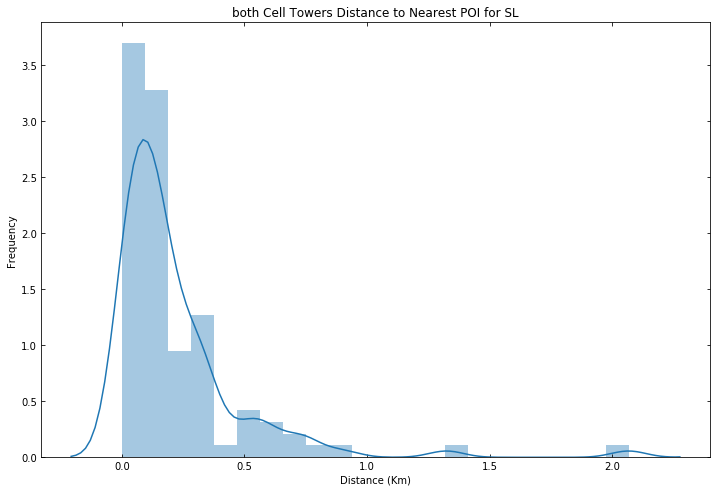

<Figure size 432x288 with 0 Axes>

In [324]:
outf = "../outputs/cellTowers/nearest_dist.png"
plot_and_save_distance_distribution(df=df2, plot_col='nearest_dist', lu_class='both', 
                                    outfile=outf, region='SL')

In [319]:
df.head()

,operator,site_id,lon,lat,within_frt,western,cell_id,lac,azimuth,beam_width,...,home,transit,work,total,prop_h,prop_w,prop_t,prop_std,lu_class,nearest_dist
0,africell,s0,-13.270600,8.447560,1,1,14358,602,130,65,...,310.0,164.0,588.0,1062.0,0.291902,0.553672,0.154426,0.165604,work,0.005117
1,africell,s1,-13.288022,8.491973,1,1,14011,600,100,65,...,533.0,278.0,888.0,1699.0,0.313714,0.522660,0.163626,0.147230,work,0.122199
2,africell,s2,-12.231110,8.712850,0,0,20601,641,25,65,...,206.0,124.0,341.0,671.0,0.307004,0.508197,0.184799,0.133333,work,0.550615
3,africell,s3,-13.160900,8.416600,1,1,12211,613,0,65,...,816.0,428.0,1421.0,2665.0,0.306191,0.533208,0.160600,0.153322,work,0.006112
4,africell,s4,-13.154100,8.430440,1,1,12041,613,185,65,...,1617.0,917.0,2799.0,5333.0,0.303206,0.524845,0.171948,0.145636,work,0.071158


In [315]:
df.nearest_dist.describe()

count    267.000000
mean       1.653871
std        3.427927
min        0.000734
25%        0.078432
50%        0.270867
75%        0.997697
max       26.953283
Name: nearest_dist, dtype: float64

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


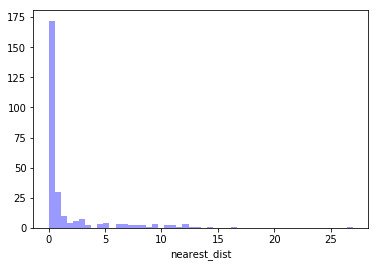

In [306]:
# Plot a simple histogram with binsize determined automatically
import seaborn as sns
sns.distplot(df.nearest_dist, kde=False, color="b")

In [297]:
df2 = df.drop_duplicates(subset=['site_id'])

In [299]:
df2.shape

(267, 33)

In [296]:
df.nearest_dist.describe()

count    2621.000000
mean        0.776408
std         2.209157
min         0.000734
25%         0.060500
50%         0.162483
75%         0.386343
max        26.953283
Name: nearest_dist, dtype: float64

In [285]:
dfloc = dfloc.filter(dfloc.wkday < 5)

In [286]:
dfloc.select("wkday").distinct().show()

+-----+
|wkday|
+-----+
|    1|
|    3|
|    4|
|    2|
|    0|
+-----+



In [165]:
# Prep params
time_params = {'timestamp':'datetime', 'datecol':'date', 'date_fmt':"%Y-%m-%d",
              'hr':'hr'}
PARAMS = prep_lu_classification_parameters(exclude_holidays=True, exclude_wkends=True, 
                                           outparam_file=params_file, results_file=cdrs, **time_params)

In [175]:
dfloc2 = dfloc.withColumn('lu_class', add_lu_class(col('hr')))

In [176]:
dfloc2.head()

Row(cellid='34090', phonenumber1='4922434041089106118', phonenumber2='231238235533002469', operator='africell', site_id='s67', lon='-13.2289', lat='8.48674', within_frt='1', western='1', lac='800', azimuth='90', beam_width='43', cell_name='3G_GODRECHSTREET-13', mcc='619', mnc='5', admin4Name='Mountain Regent', admin4Pcod='SL04020102', admin3Name='Central I', admin3Pcod='SL040201', admin2Name='Western Area Urban', admin2Pcod='SL0402', admin1Name='Western', admin1Pcod='SL04', popCnt2015='8132.562', datetime=datetime.datetime(2018, 1, 27, 14, 17, 43), date=datetime.date(2018, 1, 27), month=1, hr=14, wkday=5, date_str='2018-01-27', lu_class='work')

In [253]:
dfgrp = dfloc2.groupBy(['site_id', 'lu_class']).agg({"lu_class": "count"})
pdf = dfgrp.repartition(10).toPandas()
pdf.rename(columns={'count(lu_class)':'count'}, inplace=True)
pdf2 = pdf.pivot(index='site_id', columns='lu_class')
pdf2.columns = pdf2.columns.droplevel(0)
pdf2.columns.name = None
pdf2['site_id'] = pdf2.index
df = classify_into_lu(how='simple_max', df=pdf2)

In [255]:
df.lu_class.value_counts()

work    255
Name: lu_class, dtype: int64

In [222]:
pdf2['total'] = pdf2.sum(axis=1)

In [256]:
df.head()

,home,transit,work,site_id,total,prop_h,prop_w,prop_t,prop_std,lu_class
site_id,,,,,,,,,,
s0,424,232,767,s0,1423,0.297962,0.539002,0.163036,0.155512,work
s1,723,372,1231,s1,2326,0.310834,0.529235,0.159931,0.151605,work
s10,672,473,1170,s10,2315,0.290281,0.505400,0.204320,0.126629,work
s100,439,317,1176,s100,1932,0.227226,0.608696,0.164079,0.196410,work
s101,1150,607,2275,s101,4032,0.285218,0.564236,0.150546,0.172281,work


In [242]:
np.std([0.4, 0.3, 0.3])

0.04714045207910318

In [276]:
def to_date_formatted(date_str, format, s):
    print(s)
    if date_str == '' or date_str is None:
        return None
    try:
        dt = datetime.datetime.strptime(date_str, format)
    except:
        return None
    return dt.date()

data = {}
data["date_str_1"] = ["01-Dec-17", "05-Jan-12", "08-Mar-15"]
data["date_str_2"] = ["01/12/17", "05/01/12", "08/03/15"]

df = pd.DataFrame(data)
df = spark.createDataFrame(df)
df.registerTempTable('df')

In [277]:
to_date_udf = udf(to_date_formatted, DateType())
df = df.withColumn("parsed_date", to_date_udf('date_str_1', lit('%d-%b-%y'), lit('Dun')))
df.show()

+----------+----------+-----------+
|date_str_1|date_str_2|parsed_date|
+----------+----------+-----------+
| 01-Dec-17|  01/12/17|       null|
| 05-Jan-12|  05/01/12|       null|
| 08-Mar-15|  08/03/15|       null|
+----------+----------+-----------+



In [210]:
pdf2['site_id'] = pdf2.index
pdf2.columns = pdf2.columns.droplevel(0)
pdf3 = pdf2.reset_index(drop=True)

lu_class,home,transit,work,
0,424,232,767,s0
1,723,372,1231,s1
2,672,473,1170,s10
3,439,317,1176,s100
4,1150,607,2275,s101


In [207]:
pdf2['site_id'] = pdf2.index

In [208]:
pdf2.head(10)

count               site_id
lu_class  home transit  work        
site_id                             
s0         424     232   767      s0
s1         723     372  1231      s1
s10        672     473  1170     s10
s100       439     317  1176    s100
s101      1150     607  2275    s101
s102      1209     678  2405    s102
s103       638     367  2201    s103
s104      1238     819  3230    s104
s105      1579     775  2259    s105
s106       194     130   302    s106

In [203]:
pdf2.columns = pdf2.columns.droplevel(0)
pdf3 = pdf2.reset_index()
pdf4 = pdf3.reset_index(drop=True)
pdf3.head()

lu_class,site_id,home,transit,work
0,s0,424,232,767
1,s1,723,372,1231
2,s10,672,473,1170
3,s100,439,317,1176
4,s101,1150,607,2275
5,s102,1209,678,2405
6,s103,638,367,2201
7,s104,1238,819,3230
8,s105,1579,775,2259
9,s106,194,130,302


In [192]:
pdf2.columns = pdf2.columns.droplevel(0)

In [193]:
pdf2.reset_index()

lu_class,site_id,home,transit,work
0,s0,424,232,767
1,s1,723,372,1231
2,s10,672,473,1170
3,s100,439,317,1176
4,s101,1150,607,2275
5,s102,1209,678,2405
6,s103,638,367,2201
7,s104,1238,819,3230
8,s105,1579,775,2259
9,s106,194,130,302


In [161]:
pdf2 = pdf.pivot(index='site_id', columns='lu_class')

In [186]:
pdf2.head()

lu_class,home,transit,work
site_id,,,
s0,424,232,767
s1,723,372,1231
s10,672,473,1170
s100,439,317,1176
s101,1150,607,2275


In [160]:
pdf.pivot?

In [110]:
d.isoweekday()

3

In [33]:
test = df.first()
test_df = create_spark_df_from_rows(test[1])

In [34]:
test_df.head()

Row(datetime='2018-01-01 19:03:25.000', cellid='12002', phonenumber1='4113919975267675094', phonenumber2='257572863773784455')

In [31]:
cellDF.head()

Row(datetime='2018-01-01 19:03:25.000', cellid='12002', phonenumber1='4113919975267675094', phonenumber2='257572863773784455')

In [14]:
for k,v in test.__iter__():
    print(type(k))

ValueError: too many values to unpack (expected 2)

## Mount Folders

In [ ]:
# Replace with your values
# NOTE: Set the access to this notebook appropriately to protect the security of your keys.
# Or you can delete this cell after you run the mount command below once successfully.
#YOUR_STORAGE_ACCOUNT_NAME = "REPLACE_WITH_YOUR_AZURE_BLOB"
STORAGE_ACCOUNT_NAME = "c344850"
#YOUR_CONTAINER_NAME = "REPLACE_WITH_YOUR_AZURE_CONTAINER"
CONTAINER_NAME = "africell-four-months"
#YOUR_DIRECTORY_NAME = "REPLACE_WITH_YOUR_DIRECTORY_NAME"
DIRECTORY_NAME = ""
#MOUNT_NAME = "REPLACE_WITH_YOUR_MOUNT_NAME"
MOUNT_NAME = "afr"

#ACCESS_KEY = "fs.azure.account.key.YOUR_STORAGE_ACCOUNT_NAME.blob.core.windows.net"
ACCESS_KEY = "fs.azure.account.key.{}.blob.core.windows.net".format(STORAGE_ACCOUNT_NAME)
#SECRET_KEY = "REPLACE_WITH_YOUR_SECRET_KEY"
SECRET_KEY = "kbqBQVOcEz7Jz30wCCVI/JzYwfjG9+6s0A6rsakRInSyj/UP9wpfxeLgzkHMevbonM5u9XhcqsgDY+j95hQdCw=="

In [ ]:
def mount_folder_from_azure_blob(storage_acc_name=None, container_name=None, 
                                 dirname=None, mnt_name=None, access_key=None, secret_key=None):
  
  """
  Utility function to mount a folder from Azure Blob storage if its not mounted
  """
  # Check if folder is arleady mounted
  mounted_folders = dbutils.fs.mounts()
  for m in mounted_folders:
    s = m.source
    if container_name in s:
      print("Arleady Mounted")
      return
  
  # Mount folder if not mounted
  configs = {access_key: secret_key}
  result = dbutils.fs.mount(
              source = "wasbs://{}@{}.blob.core.windows.net/{}".format(container_name, storage_acc_name, dirname),
              mount_point = "/mnt/{}".format(mnt_name),
              extra_configs = configs)
  
  if result:
    print("Successfully mounted folder")

In [ ]:
# Mount Container
mount_folder_from_azure_blob(storage_acc_name=STORAGE_ACCOUNT_NAME, container_name=CONTAINER_NAME, dirname=DIRECTORY_NAME,mnt_name=MOUNT_NAME, secret_key=SECRET_KEY, access_key=ACCESS_KEY)

# just check the mounted folders
display(dbutils.fs.ls("/mnt/afr/"))

In [ ]:
month_files = {'Jan': "/mnt/afr/January_2018.txt", "Feb":"/mnt/afr/February.txt","Jul": "/mnt/afr/July_2018.txt","June": "/mnt/afr/June_2018.txt"}
all_files =  "/mnt/afr/"
afr_loc = "/mnt/sample/africell-loc-with-attributes.csv"

In [ ]:
def preprocess_new_data(df=None, cols_to_keep=None, outfolder=None, use_in_and_out_calls=False, loc_df=None):
  """
  Do the following'
  1. Pick only columns which are easy to identify' phonenumber, datetime and cellid
  2. Hash phonenumber
  3. Save as a new dataset
  """
  # keep only a few columns
  cols_to_keep = ["_c1", "_c6", "_c14", "_c15"]
  df2 = df.select(*cols_to_keep)
  df3 = (df2.withColumnRenamed("_c1", "datetime")
            .withColumnRenamed("_c14", "cellid"))
  
  # hash phone numbers
  hash_numbers = udf(lambda z: abs(hash(str(z))), StringType())
  df4 =  df3.withColumn("phonenumber1", hash_numbers(col("_c6")))
  df5 =  df4.withColumn("phonenumber2", hash_numbers(col("_c15")))
  df6 =  df5.drop(*["_c6", "_c15"])
  # split into in and out calls
  df7 =  break_cdrs_into_in_and_out_calls(cdrs=df6)
  # add location
  loc_cols = ['site_id','lon','lat','cellid']
  dfloc = loc_df.withColumnRenamed('cell_id', 'cellid')
  dfloc2 = dfloc.select(*loc_cols)
  
  df8 = df7.repartition(20)
  df9 = df8.join(dfloc2, on='cellid', how='inner')
  #remove duplicates
  df10 = df9.dropDuplicates(["datetime", "phonenumber"])
  
  # save
  df10.write.csv(outfolder, header=True)

In [ ]:
def break_cdrs_into_in_and_out_calls(cdrs=None):
    """
    Takes raw CDRs and split into incoming events and outgoing events.
    """
    # keep only required columns
    out_calls = ["datetime",'phonenumber1', 'cellid']
    dfout = cdrs.select(*out_calls)
    dfout2 = dfout.withColumnRenamed('phonenumbe1', 'phonenumber')
    
    in_calls = ["datetime",'phonenumber2', 'cellid']
    dfin = cdrs.select(*in_calls)
    dfin2 = dfin.withColumnRenamed('phonenumber2', 'phonenumber')
           
    # add call type column to indicate whether its incoming or outgoing event
    dfin3 = dfin2.withColumn('call_type', lit('incoming'))
    dfout3 = dfout2.withColumn('call_type', lit('outgoing'))
    df_inout = dfin3.union(dfout3)
    
    # drop rows with no cellid because we cant do anything with no location
    df_inout2 = df_inout.filter(df_inout.cellid.isNotNull())
    
    # drop rows where userid column is null
    df_inout3 = df_inout2.filter(df_inout2['phonenumber'].isNotNull())
    
    return df_inout3

In [ ]:
# mount folder for hashed data
mount_folder_from_azure_blob(storage_acc_name=STORAGE_ACCOUNT_NAME, container_name="africell-four-months-subset", 
                             dirname="",mnt_name="afr_sub", secret_key=SECRET_KEY, access_key=ACCESS_KEY)
# just check the mounted folders
#display(dbutils.fs.ls("/mnt/afr_sub/"))

In [ ]:
df = spark.read.csv(all_files, header=False)
df.rdd.repartition(20)
outfolder =  "/mnt/afr_sub/hashed_dataset/"
# Log number of rows
# print("Number of rows before splitting: {:,}".format(df.count()))
dfloc = spark.read.csv(afr_loc, header=True)
preprocess_new_data(df=df, outfolder=outfolder, loc_df=dfloc)

In [ ]:
df = spark.read.csv(outfolder, header=True)
df.rdd.repartition(20)
print("{:,}".format(df.count()))

In [71]:
df = pd.read_csv('../data/geography/cell-towers/africell/cellTowersWithManualLUClassification.csv')

In [73]:
df.rename(columns={'Land_Use': 'manual_lu_cls'}, inplace=True)

In [74]:
df.manual_lu_cls.value_counts()

1    161
2    106
Name: manual_lu_cls, dtype: int64

In [76]:
df2 = df.replace(1, 'residential')
df3 = df2.replace(2, 'commercial')

In [77]:
df3.manual_lu_cls.value_counts()

residential    161
commercial     106
Name: manual_lu_cls, dtype: int64

In [79]:
df3.to_csv('../data/geography/cell-towers/africell/cellTowersWithManualLUClassification2.csv', index=False)